# GAM Modelling - Alpha Diversity

# 1. Package and libraries

In [13]:

library(sf)
library(dplyr)
library(ggplot2)
library(mgcv)
library(terra)
library(patchwork)

### datos 



# 2. Load data

In [14]:
grid_10_km = st_read( "Results/shp/grid_10km_samping_filter.shp")
dem_30m = rast("Data/raster/dem_30m.tif")
ecu = st_read("Data/Shp/ecuador_limits.shp")

Reading layer `grid_10km_samping_filter' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Results\shp\grid_10km_samping_filter.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 198 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


## Extract DEM data

In [15]:
# Asegurar CRS igual
dem_30m <- project(dem_30m, st_crs(grid_10_km)$wkt)
grid_vect <- vect(grid_10_km)
# Extraer valores por celda del grid
ext_vals <- extract(dem_30m, grid_vect)

# Calcular estadísticos por id
stats_elev <- ext_vals %>%
  group_by(ID) %>%
  summarise(
    elev_mean = mean(elevation, na.rm = TRUE)
  )
grid_10_km$ID = seq(1:dim(grid_10_km)[1])
grid_10km_elev <- grid_10_km %>%
  left_join(stats_elev, by = c("ID" = "ID"))
centroids <- st_centroid(grid_10km_elev)

# Extraer coordenadas como columnas X y Y
coords <- st_coordinates(centroids)

grid_10km_elev <- grid_10km_elev %>%
  mutate(
    centroid_x = coords[,1],
    centroid_y = coords[,2]
  )

head(grid_10km_elev)

Warning message:
st_centroid assumes attributes are constant over geometries 


Simple feature collection with 6 features and 20 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -3.741713 xmax: -80.14934 ymax: -0.9374151
Geodetic CRS:  WGS 84
    id     left     top    right  bottom id_10km Ttl_rcr Totl_sp Smplg_c
1  406 504459.9 9886386 514459.9 9876386     406      74      33  0.7038
2  505 514459.9 9816386 524459.9 9806386     505     109      61  0.5975
3  589 524459.9 9896386 534459.9 9886386     589     402      81  0.8882
4  595 524459.9 9836386 534459.9 9826386     595      51      25  0.6298
5 1056 574459.9 9826386 584459.9 9816386    1056     116      26  0.8622
6 1171 584459.9 9596386 594459.9 9586386    1171      82      18  0.9274
  n_rcrds sp_obs f1 f2    sc_ext n_rcrd_ sp_ext ID elev_mean
1      74     33 22  3 0.7752350     148     52  1  60.78743
2     109     61 44  7 0.7079283     218     99  2  24.95199
3     402     81 45 14 0.9400731     804    114  3  71.93604
4      51     25 19  3 0.7314652     102     4

## Create Dataframe

In [16]:
df <- grid_10km_elev %>% st_drop_geometry()

# variables
df$Totl_sp
df$elev_mean
df$centroid_x
df$centroid_y


# 3. Stadistical Modelling

## 3.1. GAM - Alpha diversity

### Model

El modelo GAM con distribución Negativa Binomial detecta una relación significativa entre la riqueza de especies y los predictores evaluados. La elevación muestra un efecto no lineal moderado pero estadísticamente significativo (edf ≈ 3.0, p = 0.00031), mientras que el efecto espacial representado por las coordenadas del centróide presenta una contribución más compleja y altamente significativa (edf ≈ 14.6, p < 2e-16), indicando variación espacial estructurada en la riqueza. El intercepto es alto, coherente con un promedio elevado de especies por celda. El modelo explica un 36.8% de la desviancia y presenta un R² ajustado modesto (0.165), lo que sugiere que, aunque capta patrones importantes, aún existe variabilidad no explicada que podría estar asociada a otros factores ambientales o de muestreo.

In [17]:
m_gam <- gam(
  Totl_sp ~ s(elev_mean) +
            s(centroid_x, centroid_y, bs = "tp"),
  family = nb(link = "log"),
  data = df,
  method = "REML"
)
summary(m_gam)


Family: Negative Binomial(2.108) 
Link function: log 

Formula:
Totl_sp ~ s(elev_mean) + s(centroid_x, centroid_y, bs = "tp")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.29471    0.04971   86.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                            edf Ref.df Chi.sq p-value    
s(elev_mean)              2.778  3.452  11.76   0.013 *  
s(centroid_x,centroid_y) 14.099 18.666  72.83  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.155   Deviance explained = 35.9%
-REML = 1047.8  Scale est. = 1         n = 198

### Checks

El Q–Q plot muestra desviaciones moderadas de la línea teórica en los cuantiles extremos, indicando colas algo más pesadas de lo esperado bajo el supuesto del modelo, pero sin evidencias fuertes de violaciones sistemáticas. El gráfico de residuos frente al predictor lineal exhibe una dispersión homogénea sin patrones definidos, lo que sugiere ausencia de heterocedasticidad importante y una correcta especificación de la función de enlace. El histograma confirma una distribución de residuos aproximadamente simétrica, con ligera asimetría positiva, compatible con modelos de conteo. En conjunto, los diagnósticos indican que el modelo es adecuado y no presenta problemas serios de ajuste, aunque existe cierta variabilidad residual que no está completamente capturada.


Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [1.309388e-08,4.526558e-07]
(score 1047.802 & scale 1).
Hessian positive definite, eigenvalue range [0.6667961,95.30732].
Model rank =  39 / 39 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                            k'   edf k-index p-value
s(elev_mean)              9.00  2.78    1.00    0.77
s(centroid_x,centroid_y) 29.00 14.10    0.97    0.61


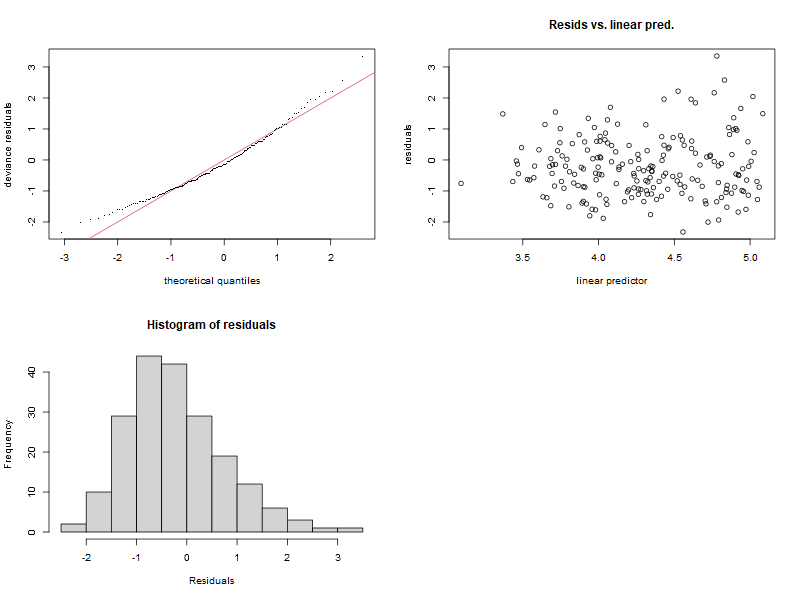

In [18]:
gam.check(m_gam)

### Concurvity

La concurvidad evalúa cuánta dependencia existe entre los efectos suaves del modelo. Valores altos indican que un término puede ser parcialmente explicado por otro, reduciendo la capacidad del modelo para estimar efectos independientes. En tus resultados, el término espacial s(centroid_x, centroid_y) muestra una concurvidad observada baja (≈ 0.247) y una concurvidad estimada aún menor (≈ 0.149), lo que indica independencia razonable respecto del resto del modelo. El suave de elevación presenta una concurvidad observada moderada (≈ 0.499), lejos de niveles problemáticos. En conjunto, no hay señales de solapamiento severo entre los predictores, y los efectos se estiman de manera estable.

In [19]:
concurvity(m_gam, full = TRUE)

                 para s(elev_mean) s(centroid_x,centroid_y)
worst    9.574507e-25    0.9361456                0.9361456
observed 9.574507e-25    0.5018928                0.2481254
estimate 9.574507e-25    0.7769693                0.1546138

### Moran test

El test de Moran I aplicado a los residuos indica ausencia de autocorrelación espacial. El valor observado de Moran I es muy cercano a cero (–0.0269), su desviación tipificada es baja (–0.57) y el p-value alto (0.716) confirma que la estructura espacial de los residuos no difiere de lo esperado bajo aleatoriedad. La expectativa teórica del índice (–0.0046) es prácticamente igual al valor observado, lo que refuerza que el modelo no deja patrones espaciales sistemáticos sin capturar.

In [20]:
library(spdep)

coords <- cbind(df$centroid_x, df$centroid_y)
nb_obj <- knn2nb(knearneigh(coords, k=5))
lw <- nb2listw(nb_obj)

moran.test(residuals(m_gam), lw)


	Moran I test under randomisation

data:  residuals(m_gam)  
weights: lw    

Moran I statistic standard deviate = -0.10886, p-value = 0.5433
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.009518656      -0.005076142       0.001665551 


### Plot predictions



El efecto de la elevación muestra una relación unimodal, con mayor riqueza en elevaciones intermedias y disminución hacia los extremos. La coordenada X presenta un gradiente espacial marcado, con un pico localizado que sugiere variación geográfica fuerte en sentido longitudinal. La coordenada Y evidencia también un patrón no lineal, indicando zonas específicas con mayor riqueza en el eje latitudinal. En conjunto, los efectos espaciales capturan heterogeneidad geográfica sustancial más allá del efecto de la elevación.

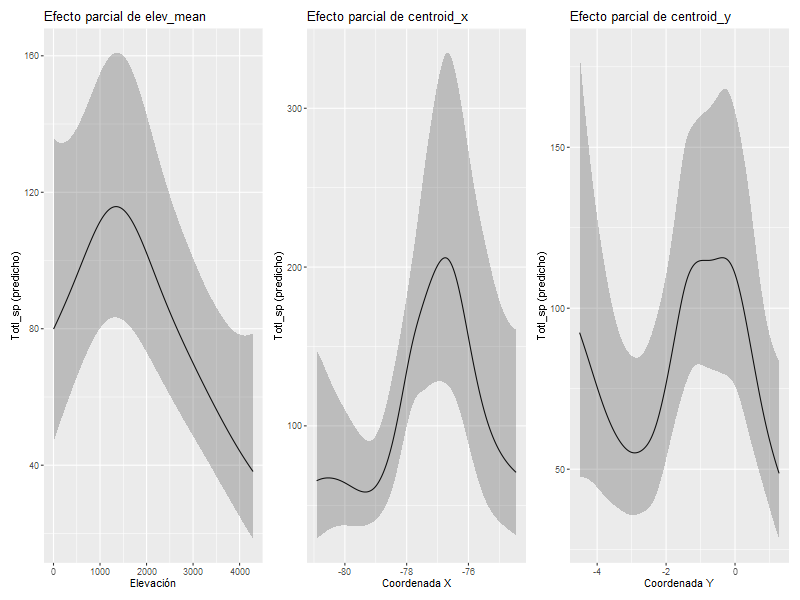

In [21]:

# ============================================================
# 1. Efecto parcial de elev_mean
# ============================================================

new_elev <- data.frame(
    elev_mean  = seq(min(df$elev_mean), max(df$elev_mean), length.out = 200),
    centroid_x = mean(df$centroid_x),
    centroid_y = mean(df$centroid_y)
)

p_elev <- predict(m_gam, newdata = new_elev, type = "link", se.fit = TRUE)

new_elev$fit   <- exp(p_elev$fit)
new_elev$lower <- exp(p_elev$fit - 2*p_elev$se.fit)
new_elev$upper <- exp(p_elev$fit + 2*p_elev$se.fit)

g1 <- ggplot(new_elev, aes(elev_mean, fit)) +
    geom_line() +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
    labs(x = "Elevación", y = "Totl_sp (predicho)") +
    ggtitle("Efecto parcial de elev_mean")


# ============================================================
# 2. Efecto parcial de centroid_x
# ============================================================

new_x <- data.frame(
    centroid_x = seq(min(df$centroid_x), max(df$centroid_x), length.out = 200),
    centroid_y = mean(df$centroid_y),
    elev_mean  = mean(df$elev_mean)
)

p_x <- predict(m_gam, newdata = new_x, type = "link", se.fit = TRUE)

new_x$fit   <- exp(p_x$fit)
new_x$lower <- exp(p_x$fit - 2*p_x$se.fit)
new_x$upper <- exp(p_x$fit + 2*p_x$se.fit)

g2 <- ggplot(new_x, aes(centroid_x, fit)) +
    geom_line() +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
    labs(x = "Coordenada X", y = "Totl_sp (predicho)") +
    ggtitle("Efecto parcial de centroid_x")


# ============================================================
# 3. Efecto parcial de centroid_y
# ============================================================

new_y <- data.frame(
    centroid_y = seq(min(df$centroid_y), max(df$centroid_y), length.out = 200),
    centroid_x = mean(df$centroid_x),
    elev_mean  = mean(df$elev_mean)
)

p_y <- predict(m_gam, newdata = new_y, type = "link", se.fit = TRUE)

new_y$fit   <- exp(p_y$fit)
new_y$lower <- exp(p_y$fit - 2*p_y$se.fit)
new_y$upper <- exp(p_y$fit + 2*p_y$se.fit)

g3 <- ggplot(new_y, aes(centroid_y, fit)) +
    geom_line() +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
    labs(x = "Coordenada Y", y = "Totl_sp (predicho)") +
    ggtitle("Efecto parcial de centroid_y")


# ============================================================
# 4. Figura final combinada
# ============================================================

(g1 | g2 | g3)


## 3.2. Prediction Alpha diversity

In [22]:

# =========================================================
# 1. Cargar límite de Ecuador y DEM en WGS84
# =========================================================

ecu <- st_read("Data/Shp/ecuador_limits.shp") |>
  st_transform(4326) |>
  st_make_valid()

ecu_v <- vect(ecu)

dem_30m <- rast("Data/raster/dem_30m.tif")
dem_30m <- project(dem_30m, "EPSG:4326")


# =========================================================
# 2. Crear raster vacío de 10 km cubriendo todo Ecuador
# =========================================================

ext_ecu <- ext(ecu_v)

# resolución equivalente a 10 km
res_deg <- 10000 / 111320     # ≈ 0.089932°

r10 <- rast(
  extent = ext_ecu,
  resolution = res_deg,
  crs = "EPSG:4326",
  nlyrs = 1
)
names(r10) <- "prediction"


# =========================================================
# 3. Extraer coordenadas de cada celda
# =========================================================

coords <- crds(r10, df = TRUE)
colnames(coords) <- c("centroid_x", "centroid_y")


# =========================================================
# 4. Extraer elevación desde DEM
# =========================================================

elev_df <- extract(dem_30m, coords[, c("centroid_x", "centroid_y")])
df_pred <- cbind(coords, elev_mean = elev_df[,2])

# eliminar NA
df_pred <- df_pred[!is.na(df_pred$elev_mean), ]


# =========================================================
# 5. Predecir GAM en TODA LA ZONA
# =========================================================

pred_vals <- predict(
  m_gam,
  newdata = df_pred,
  type = "response"
)

df_pred$pred <- pred_vals


# =========================================================
# 6. Insertar predicciones en raster
# =========================================================

r_pred <- r10

cell_ids <- cellFromXY(r_pred, df_pred[, c("centroid_x", "centroid_y")])

vals <- rep(NA, ncell(r_pred))
vals[cell_ids] <- df_pred$pred

r_pred <- setValues(r_pred, vals)


# =========================================================
# 7. Máscara: limitar SOLO a Ecuador
# =========================================================

r_pred_ecu <- mask(r_pred, ecu_v)




Reading layer `ecuador_limits' from data source 
  `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


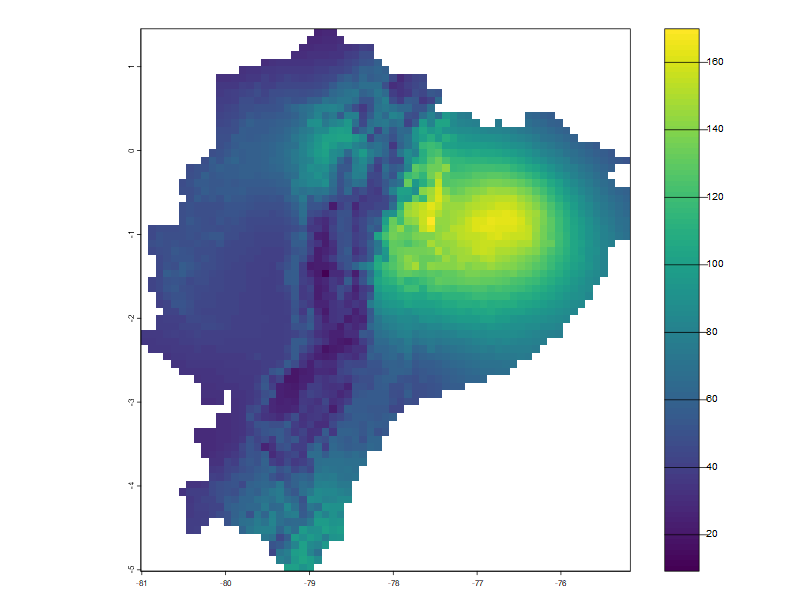

In [23]:
plot(r_pred_ecu)

# 4. Exportar resultados

In [24]:
# =========================================================
# 8. Guardar raster final
# =========================================================

writeRaster(
  r_pred_ecu,
  "Results/raster/GAM_prediction_alpha.tif",
  overwrite = TRUE
)